In [1]:
import datetime
import time
import numpy as np
import networkx as nx
import random
from collections import defaultdict
from dateutil.relativedelta import *
from networkx.drawing.nx_agraph import graphviz_layout
from scipy import optimize
import graph
from importlib import reload
import as_rank
from as_rank import query_as_rank
reload(as_rank)
reload(graph)

from graph import IPv6Graph
from scipy.misc import derivative
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use('svg')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams.update({'font.size': 8})
from statsmodels.distributions.empirical_distribution import ECDF
from networkx.readwrite import json_graph
import json

In [2]:
def plot_histogram(l, fname, title, bins):
    fig, axs = plt.subplots(1, 1, figsize=(3.25, 2.25))
    plt.hist(l, bins=bins)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

def plot_cdf(l, fname, title, xlabel):
    fig, axs = plt.subplots(1, 1, figsize=(3.25, 2.25))
    ecdf = ECDF(l)
    plt.plot(ecdf.x, ecdf.y)
    plt.xlabel(xlabel)
    plt.ylabel('Probability')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

def plot_2_cdf(l1, l2, fname, title, xlabel1, xlabel2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.4, 1.5), sharey=True)
    fig.suptitle(title)
    ecdf1 = ECDF(l1)
    ecdf2 = ECDF(l2)
    ax1.plot(ecdf1.x, ecdf1.y)
    ax1.set(xlabel=xlabel1, ylabel='Probability')
    ax2.plot(ecdf2.x, ecdf2.y)
    ax2.set(xlabel=xlabel2)
    plt.tight_layout()
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [3]:
start_date = datetime.date(year=2008, month=12, day=1)
end_date = datetime.date(year=2020, month=4, day=1)
ipv6_graph = IPv6Graph(start_date, end_date)
ipv6_nodes_monthly = ipv6_graph.build_graph()

12/2008
# IPv6 nodes:  411
01/2009
# IPv6 nodes:  453
02/2009
# IPv6 nodes:  474
03/2009
# IPv6 nodes:  496
04/2009
# IPv6 nodes:  509
05/2009
# IPv6 nodes:  523
06/2009
# IPv6 nodes:  545
07/2009
# IPv6 nodes:  549
08/2009
# IPv6 nodes:  575
09/2009
# IPv6 nodes:  582
10/2009
# IPv6 nodes:  594
11/2009
# IPv6 nodes:  729
12/2009
# IPv6 nodes:  746
01/2010
# IPv6 nodes:  760
02/2010
# IPv6 nodes:  770
03/2010
# IPv6 nodes:  782
04/2010
# IPv6 nodes:  789
05/2010
# IPv6 nodes:  805
06/2010
# IPv6 nodes:  817
07/2010
# IPv6 nodes:  842
08/2010
# IPv6 nodes:  1005
09/2010
# IPv6 nodes:  1058
10/2010
# IPv6 nodes:  1111
11/2010
# IPv6 nodes:  1145
12/2010
# IPv6 nodes:  1169
01/2011
# IPv6 nodes:  1294
02/2011
# IPv6 nodes:  1341
03/2011
# IPv6 nodes:  1388
04/2011
# IPv6 nodes:  1422
05/2011
# IPv6 nodes:  1702
06/2011
# IPv6 nodes:  1771
07/2011
# IPv6 nodes:  1819
08/2011
# IPv6 nodes:  1855
09/2011
# IPv6 nodes:  1883
10/2011
# IPv6 nodes:  1934
11/2011
# IPv6 nodes:  2214
12/2011
# IP

In [4]:
max_neighbors = 0
max_node = None
min_neighbors = float('inf')
neighbors = []
ipv6_neighbors = []
for node in ipv6_graph.G.nodes:
    num_neighbors = len(list(ipv6_graph.G.neighbors(node)))
    if num_neighbors > max_neighbors:
        max_neighbors = num_neighbors
        max_node = node
    if num_neighbors < min_neighbors:
        min_neighbors = num_neighbors
    neighbors.append(num_neighbors)
    if ipv6_graph.G.nodes[node].get('ipv6'):
        ipv6_neighbors.append(len(ipv6_graph.G.nodes[node].get('ipv6_neighbors')))
print(max_node, max_neighbors, min_neighbors, np.mean(neighbors), np.std(neighbors), np.mean(ipv6_neighbors), np.std(ipv6_neighbors))

6939 12971 1 22.64774131621573 165.7194351247997 11.880957957606277 32.915194956063324


In [5]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(np.concatenate([y[0].repeat(box_pts-1), y, y[-1].repeat(box_pts-1)]), box, mode='valid')[box_pts-1:]
    return y_smooth

16008


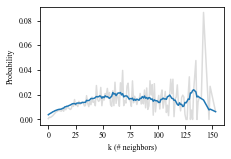

In [6]:
pl = defaultdict(list)
for t, d in ipv6_graph.adoption_dict.items():
    for k, v in d.items():
        na = v['not_adopted']
        a = v['adopted']
        pl[k].append(a / float(a + na))

pl_ = {}
num_dp = 0
for k, v in pl.items():
#     print(k, len(v))
    if len(v) > 50:
        pl_[k] = np.mean(pl[k])
        num_dp += len(v)
print(num_dp)
xy = []
for k, v in pl_.items():
    xy.append((k, v))
xy = sorted(xy)
x = [d[0] for d in xy]
y = [d[1] for d in xy]

fig, axs = plt.subplots(1, 1, figsize=(3.25, 2.25))
plt.plot(x, y, c='gainsboro')
plt.plot(x, smooth(y, 10))
plt.ylabel('Probability')
plt.xlabel('k (# neighbors)')
plt.tight_layout()
plt.savefig('figures/prob_adoption.pdf', bbox_inches='tight')
plt.show()

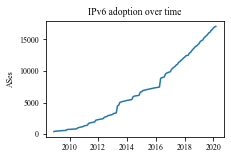

In [7]:
x = []
y = []
for k, v in ipv6_nodes_monthly.items():
    x.append(k)
    y.append(v)
fig, axs = plt.subplots(1, 1, figsize=(3.25, 2.25))
plt.plot(x, y)
plt.title('IPv6 adoption over time')
plt.ylabel('ASes')
plt.tight_layout()
plt.savefig('figures/ipv6_adoption_over_time.pdf', bbox_inches='tight')
plt.show()

In [8]:
G_ = ipv6_graph.G

months_between_last_adoption = []
months_between_first_adoption = []
for node in ipv6_graph.ipv6_nodes:
    n = G_.nodes[node]
    time_adopted = n.get('time_adopted')
    num_neighbors = n.get('num_neighbors')
    ipv6_neighbors = n.get('ipv6_neighbors')
    if len(ipv6_neighbors) > 0:
        neighbor_last_adopted = n.get('neighbor_last_adopted')
        neighbor_first_adopted = n.get('neighbor_first_adopted')
        months = diff_month(time_adopted, neighbor_last_adopted)
        months_between_last_adoption.append(diff_month(time_adopted, neighbor_last_adopted))
        months_between_first_adoption.append(diff_month(time_adopted, neighbor_first_adopted))

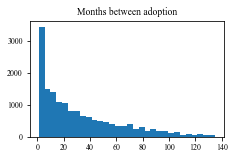

In [9]:
plot_histogram(months_between_last_adoption, 'figures/months_between_last_adoption.pdf', 'Months between adoption', bins=30)

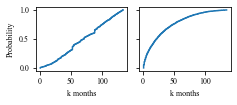

In [10]:
plot_2_cdf(months_between_first_adoption, months_between_last_adoption, 'figures/months_between_adoption.pdf', '', 'k months', 'k months')

In [11]:
num_ipv6_neighbors_list = []
for node in ipv6_graph.ipv6_nodes:
    n = G_.nodes[node]
    num_ipv6_neighbors = len(n.get('ipv6_neighbors'))
    num_ipv6_neighbors_list.append(num_ipv6_neighbors)
print(np.mean(num_ipv6_neighbors_list))

11.880957957606277


In [12]:
frac_ipv6_neighbors = []
for node in ipv6_graph.ipv6_nodes:
    n = G_.nodes[node]
    num_ipv6_neighbors = len(n.get('ipv6_neighbors'))
    num_neighbors = n.get('num_neighbors')
    frac_ipv6_neighbors.append(num_ipv6_neighbors / float(num_neighbors) * 100.)

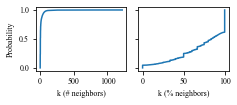

In [13]:
plot_2_cdf(num_ipv6_neighbors_list, frac_ipv6_neighbors, 'figures/ipv6_neighbors.pdf', '', 'k (# neighbors)', 'k (% neighbors)')

In [14]:
cascade_sizes = []
cascade_depths = []
cascade_size_dict = {}
cascade_depth_dict = {}
cascade_size_small = []
initial_nodes = filter(lambda x: len(G_.nodes[x].get('ipv6_neighbors', [0])) == 0, G_.nodes)
for node in initial_nodes:
    cascade_size = ipv6_graph.calculate_cascade_size(node, set())
    cascade_depth = ipv6_graph.calculate_cascade_depth(node, 0, set())
    cascade_depths.append(cascade_depth)
    cascade_sizes.append(cascade_size)
    if cascade_size < 50 and cascade_depth > 3:
        cascade_size_small.append(node)
    cascade_size_dict[cascade_size] = node
    cascade_depth_dict[cascade_depth] = node

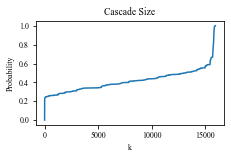

In [15]:
plot_cdf(cascade_sizes, 'figures/cascade_sizes.pdf', 'Cascade Size', 'k')

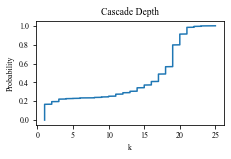

In [16]:
plot_cdf(cascade_depths, 'figures/cascade_depths.pdf', 'Cascade Depth', 'k')

In [17]:
def build_graph(node, seen_nodes, c_G, G):
    time_adopted = G.nodes[node]['time_adopted']
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] > time_adopted:
            c_G.add_edge(node, neighbor)
            if neighbor not in seen_nodes:
                seen_nodes.add(neighbor)
                c_G = build_graph(neighbor, seen_nodes, c_G, G)
    return c_G

def draw_graph(root_node, G):
    c_G = build_graph(root_node, set(), nx.DiGraph(), G)
    time_adopted_set = set([G.nodes[root_node]['time_adopted']])
    for node in c_G.nodes:
        time_adopted_set.add(G.nodes[node]['time_adopted'])
    time_adopted_list = sorted(list(time_adopted_set))
    node_colors = range(len(time_adopted_list))
    node_color_list = []
    labels = {}
    for node in c_G.nodes:
        labels[node] = time_adopted_list.index(G.nodes[node]['time_adopted'])
        node_color_list.append(node_colors[time_adopted_list.index(G.nodes[node]['time_adopted'])])
    pos=graphviz_layout(c_G, prog='dot')
    print(node_color_list)
    node_color_list = [x+5 for x in node_color_list]
    nx.draw(c_G, pos=pos, node_color=node_color_list, cmap=plt.cm.Blues, node_size=25, arrows=False, width=0.5, vmin=0)

def draw_graphs(root_nodes, fname, G):  
    print(root_nodes)
    plt.subplot(231)
    draw_graph(root_nodes[0], G)
    
    plt.subplot(232)
    draw_graph(root_nodes[1], G)
    
    plt.subplot(233)
    draw_graph(root_nodes[2], G)
    
    plt.subplot(234)
    draw_graph(root_nodes[3], G)
    
    plt.subplot(235)
    draw_graph(root_nodes[4], G)
    
    plt.subplot(236)
    draw_graph(root_nodes[5], G)


    plt.tight_layout()
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

[206884, 135125, 59494, 135610, 55466, 133149]
[0, 1, 6, 2, 9, 7, 4, 6, 5, 12, 8, 13, 6, 9, 10, 12, 13, 11, 11, 11, 13, 13, 3]
[0, 1, 12, 5, 10, 9, 9, 4, 9, 8, 8, 9, 12, 2, 12, 2, 1, 8, 10, 11, 10, 9, 2, 3, 12, 5, 13, 9, 7, 11, 2, 9, 6, 9, 3]
[0, 1, 4, 3, 2, 3, 6, 4, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 5, 5, 6, 5, 5, 2, 5, 3, 4]
[0, 1, 2, 3, 4, 7, 6, 5, 6, 9, 7, 8, 8, 8, 9, 8, 8, 8, 8, 9, 9, 8, 8, 9, 8, 8, 5, 8, 6, 7, 1]
[0, 1, 6, 8, 2, 9, 5, 6, 4, 5, 7, 5, 5, 5, 4, 3]
[0, 2, 5, 11, 4, 8, 11, 10, 9, 10, 13, 11, 12, 12, 12, 13, 12, 12, 12, 12, 13, 13, 12, 12, 13, 12, 12, 9, 12, 10, 11, 6, 7, 1, 3, 2]


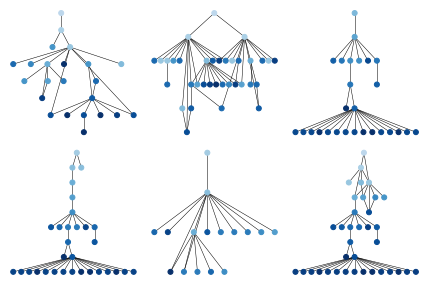

In [18]:
draw_graphs([206884, 135125, 59494, 135610, 55466, 133149], 'figures/cascade_examples.pdf', G_)

In [19]:
nodes = [3356, 1299, 174, 3257, 2914, 13101, 34549, 206499, 6762, 6939, 6453, 6461, 3491, 3549, 1273, 9002, 5511, 4637, 12956, 7473, 209, 12389, 3320, 7018, 701, 7922, 20485, 3216, 16735, 31133, 9498, 6830, 1239,52320, 2828, 20764, 15412, 8359, 286, 10429]

In [20]:
top10_cascade_size = []
top10_cascade_depth = []
for node in nodes:
    cascade_size = ipv6_graph.calculate_cascade_size(node, set())
    cascade_depth = ipv6_graph.calculate_cascade_depth(node, 0, set())
    top10_cascade_size.append(cascade_size)
    top10_cascade_depth.append(cascade_depth)

In [21]:
print(np.mean(top10_cascade_size))
print(np.mean(top10_cascade_depth))

14502.375
18.425
